In [10]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def unifySources():
    
    # path
    os.chdir("/home/marios/data_mining/project_mining_2022/part1/sources")

    # list filled with the files of the above folder
    files = os.listdir()

    li = [] # initialize list

    # traverse through all the files of the specific folder
    for file in files:
        if os.stat(file).st_size!=0: # check if file is empty
            df = pd.read_csv(file, index_col = None, header = 0)
            df.columns = map(str.lower, df.columns) # lower all column names for better concat
            Y = file[0:4]
            M = file[4:6]
            D = file[6:8]
            date_string = '-'.join([Y, M, D])
            df['date'] = date_string # add an extra column which represents the date
            df.drop_duplicates(subset = "time", keep = "first", inplace = True) #first and last row of each csv file is the same 
            li.append(df)

    sources = pd.concat(li, axis = 0, ignore_index = True)

    # remove duplicates
    sources.drop_duplicates(inplace = True)

    # replace NaN values with zeros 
    sources.fillna(0, inplace = True)

    # sort sources based on date and time (ascending)
    sources.sort_values(["date", 'time'], ascending = [True, True], inplace = True)

    return sources

In [3]:
def unifyDemands():
    
    os.chdir("/home/marios/data_mining/project_mining_2022/part1/demand")

    files = os.listdir()

    li = [] 

    for file in files:
        if os.stat(file).st_size!=0:
            df = pd.read_csv(file, index_col = None, header = 0)
            df.columns = map(str.lower, df.columns) 
            Y = file[0:4]
            M = file[4:6]
            D = file[6:8]
            date_string = '-'.join([Y, M, D])
            df['date'] = date_string
            df.drop_duplicates(subset = "time", keep = "first", inplace = True) #first and last row of each csv file is the same (00:00 time)
            li.append(df)

    demand = pd.concat(li, axis = 0, ignore_index = True)

    #remove duplicates
    demand.drop_duplicates(inplace = True)

    #remove rows containing NULL values 
    demand.fillna(0, inplace = True)

    demand.sort_values(["date", 'time'], ascending = [True, True], inplace = True)

    return demand


In [4]:
demand = unifyDemands()
sources = unifySources()
dates = demand["date"].unique() # get all the possible dates

# store the dataframes to csv's for easier access
sources.to_csv("/home/marios/data_mining/project_mining_2022/part1/sources.csv")
demand.to_csv("/home/marios/data_mining/project_mining_2022/part1/demand.csv")


In [5]:
# create a new dataframe in which will be stored the statistic values of each day
def statisticsDayDemand(demand):
    
    df_columns = ['mean', 'variance', 'kurtosis', 'skewness', 'date'] # columns of the dataframe
    statistics = pd.DataFrame(columns = df_columns, dtype=object) # create dataframe

    for date in dates:
        # calculate the statistic values and store them in the dataframe
        mean = demand.loc[demand["date"]==date]['current demand'].mean(axis=0)
        var = demand.loc[demand["date"]==date]['current demand'].var(axis=0)
        skew = demand.loc[demand["date"]==date]['current demand'].skew(axis=0)
        kurtosis = demand.loc[demand["date"]==date]['current demand'].kurtosis(axis=0)
        statistics.loc[len(statistics.index)] = [mean, var, skew, kurtosis, date]

    return statistics


In [6]:
# create a new dataframe in which will be stored the statistic values of each month
def statisticsMonthsDemand(demand, dates3, months):
    
    cnt = 0 # counter based on the amount of the months (i.e. every three months)
    statistics3 = pd.DataFrame(columns = ["mean", "variance", "skewness", "kurtosis", "date"], dtype=object)
    temp = pd.DataFrame(columns =  demand.columns, dtype=object)

    for date in dates3:
        temp = pd.concat([temp, demand.loc[demand["date"].str.contains(date)]])
        cnt = cnt + 1
        if cnt == months:
            mean = temp["current demand"].mean(axis=0)
            var = temp["current demand"].var(axis=0)
            skew = temp["current demand"].skew(axis=0)
            kurtosis = temp["current demand"].kurtosis(axis=0)
            statistics3 = pd.concat([statistics3, pd.DataFrame({"mean":[mean], "variance":[var], "skewness":[skew], "kurtosis":[kurtosis], "date":[date]})], ignore_index = True)
            temp = pd.DataFrame(columns = demand.columns, dtype=object)
            cnt = 0

    return statistics3



In [11]:
# the csv files after the pre-proccess (demand and sources) 
# are stored in the zip file
# use them in order to convert them to dataframes 

months = [d[:-3] for d in dates]
months = sorted(list(set(months)))

statistics = statisticsDayDemand(demand)
statistics3 = statisticsMonthsDemand(demand, months, 3)
statistics12 = statisticsMonthsDemand(demand, months, 12)

# store the csv files for easier access
statistics.to_csv("/home/marios/data_mining/project_mining_2022/part1/statistics.csv")
statistics3.to_csv("/home/marios/data_mining/project_mining_2022/part1/statistics3.csv")
statistics12.to_csv("/home/marios/data_mining/project_mining_2022/part1/statistics12.csv")


KeyboardInterrupt: 

In [12]:
# calculate the duck Curve (current demand - solar energy)
def duckCurve(demand, sources):

    solarEnergy = sources["solar"].reset_index(drop = True).copy()
    currentDemand = demand[['current demand', 'date']].copy()

    temp = currentDemand['current demand'] - solarEnergy
    currentDemand['without solar'] = temp

    total = currentDemand.groupby('date')

    return total


total = duckCurve(demand, sources)

# plot the results
def plotDuck(total, date):

    ttl = total.get_group(date).reset_index(drop =True)
    plt.plot(ttl['current demand'])
    plt.plot(ttl['without solar'])
    plt.show()

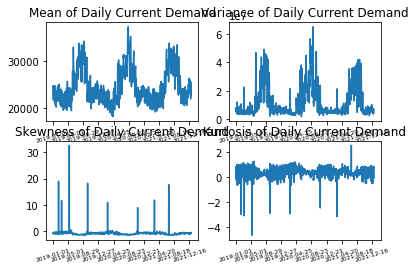

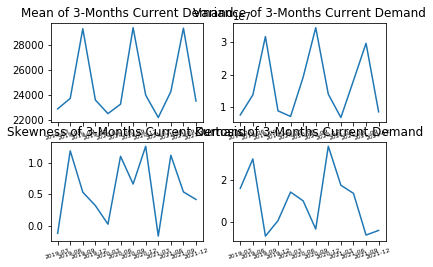

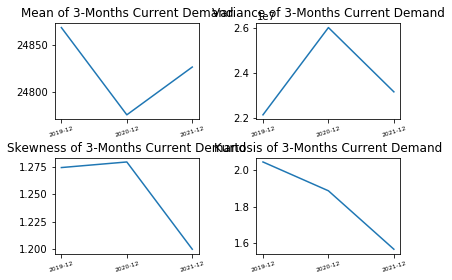

In [13]:
# plot everything that we have calculated


# statistic values for every day (demands)
plt.figure(1)
days = 120
labels = statistics["date"][0::days]
ticks = [x for x in range(0,len(statistics["date"]),days)]

plt.subplot(2,2,1)
plt.plot(statistics["mean"])
plt.xticks(ticks, labels, rotation = 17, fontsize = 6)
plt.title("Mean of Daily Current Demand")
plt.subplot(2,2,2)
plt.plot(statistics["variance"])
plt.xticks(ticks, labels, rotation = 17, fontsize = 6)
plt.title("Variance of Daily Current Demand")
plt.subplot(2,2,3)
plt.plot(statistics["skewness"])
plt.xticks(ticks, labels, rotation = 17, fontsize = 6)
plt.title("Skewness of Daily Current Demand")
plt.subplot(2,2,4)
plt.plot(statistics["kurtosis"])
plt.title("Kurtosis of Daily Current Demand")
plt.xticks(ticks, labels, rotation = 17, fontsize = 6)

# statistic values for every 3 months (demands)
plt.figure(2)
days = 1
labels = statistics3["date"][0::days]
ticks = [x for x in range(0,len(statistics3["date"]),days)]

plt.subplot(2,2,1)
plt.plot(statistics3["mean"])
plt.xticks(ticks, labels ,rotation = 17,fontsize = 6)
plt.title("Mean of 3-Months Current Demand")
plt.subplot(2,2,2)
plt.plot(statistics3["variance"])
plt.xticks(ticks, labels ,rotation = 17,fontsize = 6)
plt.title("Variance of 3-Months Current Demand")
plt.subplot(2,2,3)
plt.plot(statistics3["skewness"])
plt.xticks(ticks, labels ,rotation = 17,fontsize = 6)
plt.title("Skewness of 3-Months Current Demand")
plt.subplot(2,2,4)
plt.plot(statistics3["kurtosis"])
plt.title("Kurtosis of 3-Months Current Demand")
plt.xticks(ticks, labels ,rotation = 17,fontsize = 6)

# statistic values for every 12 months (demands)

plt.figure(3)
days = 1
labels = statistics12["date"][0::days]
ticks = [x for x in range(0,len(statistics12["date"]),days)]

plt.subplot(2,2,1)
plt.plot(statistics12["mean"])
plt.xticks(ticks, labels ,rotation=17,fontsize = 6)
plt.title("Mean of 3-Months Current Demand")
plt.subplot(2,2,2)
plt.plot(statistics12["variance"])
plt.xticks(ticks, labels ,rotation=17,fontsize = 6)
plt.title("Variance of 3-Months Current Demand")
plt.subplot(2,2,3)
plt.plot(statistics12["skewness"])
plt.xticks(ticks, labels ,rotation=17,fontsize = 6)
plt.title("Skewness of 3-Months Current Demand")
plt.subplot(2,2,4)
plt.plot(statistics12["kurtosis"])
plt.title("Kurtosis of 3-Months Current Demand")
plt.xticks(ticks, labels ,rotation=17,fontsize = 6)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# duck curve
plt.figure(4)
for i in range(8):
    plt.subplot(2,4,i+1)
    plotDuck(total, np.random.choice(dates))
plt.xlabel("Time(5min)")
plt.ylabel("Energy Units")

plt.show()

# end of first exercise  

In [28]:
# calculate all the mean sources of each day
def statisticsDaySources(sources):
    
    # drop unnecessary columns so they dont affect the mean 
    sourcesalt = sources.drop(columns = ['Unnamed: 0', 'time'])
    n = sourcesalt.shape[1] # number of columns 
    meanSources = sourcesalt.groupby('date').mean() # mean of every source of every day
    meanSources["mean"] = meanSources.sum(axis=1)/n # mean of every source each day (we dont count the column date thus n-1)

    return meanSources.reset_index(drop = True)


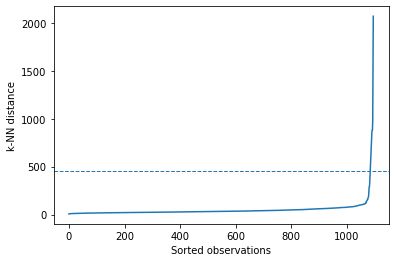

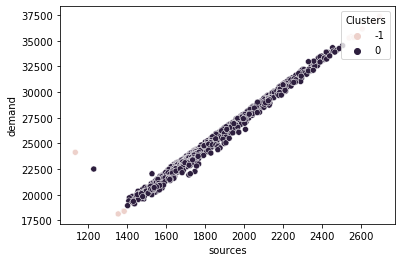

['2019-01-02', '2020-04-11', '2020-04-12', '2020-04-19', '2020-08-14', '2020-08-15', '2020-08-17', '2020-08-18', '2020-08-19', '2020-09-06']


In [60]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import seaborn as sns 

# prepare the dataset that will be the input of the dbscan
cdf = pd.DataFrame(columns=["demand", "sources", 'date'], dtype = object)
cdf["demand"] = statistics["mean"]
temp = statisticsDaySources(sources)
cdf["sources"] = temp['mean']
cdf["date"] = statistics["date"]

clusterdf = cdf.drop(columns = ['date'])
clusterdf.dropna(inplace = True)

nrstNeighbors = NearestNeighbors().fit(clusterdf)
nDistance, nInd = nrstNeighbors.kneighbors(clusterdf)
sortedNeighborDistance = np.sort(nDistance, axis = 0)
kDistance = sortedNeighborDistance[:, 4]

# apply the elbow method in order to find the ε for the dbscan
plt.figure(5)
plt.plot(kDistance)
plt.axhline(y = 450, linewidth = 1, linestyle = 'dashed')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations")
plt.show()

# search clusters using DBSCAN
# we have 2 features (demand and sources) 
# which means that samples 2*2 = 4
clusters = DBSCAN(eps = 400, min_samples = 4).fit(clusterdf)

# plot the sources and demands of everyday day
plt.figure(6)
p = sns.scatterplot(data = clusterdf, x = "sources", y = "demand", hue = clusters.labels_, legend = "full")
sns.move_legend(p, "upper right", title='Clusters')
plt.show()

# find the outliers which were detected using DBSCAN
outliers = clusterdf[clusters.labels_ == -1]
outlierDates = []

for i,j in zip(outliers.demand,outliers.sources):
    outlierDates.append(cdf.loc[(abs(clusterdf['demand']-i)<10e-5) & (abs(cdf['sources']-j)<10e-5)]["date"].values[0])

print(outlierDates)

# end of 2nd exercise


In [12]:
from sklearn.preprocessing import MinMaxScaler

# remove the outliers that were
# found with the use of DBSCAN
demand = demand[demand["date"].isin(outlierDates) == False]
sources = sources[sources["date"].isin(outlierDates) == False]

# creating a dataset that contains 
# only the renewable sources
fSources = sources[["imports", "coal", "natural gas", "batteries", "other", "nuclear"]]
fSources = fSources.sum(axis=1)
renewSources = (demand["current demand"] - fSources ).to_frame().dropna()[:2*365*288]

# create train (75% of the data) and
# test set (25% oof the data) 
# which will be given as an input
teSize = int(len(renewSources) * 0.25)
trSize = int(len(renewSources) * 0.75)
testSet = renewSources.iloc[trSize:]
trainSet = renewSources.iloc[:trSize]

# min max scale transform of the data
dataScaler = MinMaxScaler()
dataScaler.fit(trainSet)
scaledTrain = dataScaler.transform(trainSet)
scaledSet = dataScaler.transform(testSet)

ModuleNotFoundError: No module named 'numpy.testing'

In [5]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras import models

# create the lstm newtork
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
inputNum = 4
featuresNum = 1
generator = TimeseriesGenerator(scaledTrain, scaledTrain, length=inputNum, batch_size = 16)

model = Sequential()
model.add(LSTM(50, activation = 'tanh', input_shape = (inputNum, featuresNum)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()
model.fit(generator, epochs = 5, batch_size = 16, verbose = 2) # parameters of the LSTM
model.save("/home/marios/data_mining/project_mining_2022/part1/modelLSTM")

model = models.load_model("/home/marios/data_mining/project_mining_2022/part1/modelLSTM")
testPredictions = model.predict(scaledSet)
truePredictions = dataScaler.inverse_transform(testPredictions)
test = np.zeros(len(scaledTrain))
test = np.concatenate((test, truePredictions), axis = None)

plt.figure(7)
plt.plot(renewSources.sum(axis = 1, numeric_only = True).reset_index(drop = True))
plt.plot(test)
plt.xlabel("")
plt.title("Renewable Energy (Predicted and Actual Values)")
plt.xlabel("Time every 5mins)",fontweight = "bold")
plt.ylabel("Energy Units", fontweight = "bold")
plt.ylim([-1000,50_000])
plt.legend(["Actual Value", "Predicted Value"])
plt.show()


2022-06-24 21:01:21.943551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-24 21:01:21.943597: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


NameError: name 'scaledTrain' is not defined